In [44]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [45]:
pd.options.display.max_columns = None  # Show all columns
pd.options.display.max_rows = 500

Our goal in this EDA is to predict the log1p of trip_duration column,
The data is mostly clean so the EDA will be mainly focused on feature engineering to improve our model.
We will be using a Ridge model with alpha=1 as a fixed model to maximazie the experience of feature engineering.

## EDA
### 1. Initial Data Understanding
- Data Loading and Inspection
- Missing Values
- Duplicates

In [46]:
df = pd.read_csv("../data/split/train.csv")
df.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2793718,2,2016-06-08 07:36:19,1,-73.985611,40.735943,-73.980331,40.760468,N,1040
1,id3485529,2,2016-04-03 12:58:11,1,-73.978394,40.764351,-73.991623,40.749859,N,827
2,id1816614,2,2016-06-05 02:49:13,5,-73.989059,40.744389,-73.973381,40.748692,N,614
3,id1050851,2,2016-05-05 17:18:27,2,-73.990326,40.731136,-73.991264,40.748917,N,867
4,id0140657,1,2016-05-12 17:43:38,4,-73.789497,40.646675,-73.987137,40.759232,N,4967


- **Checking for Missing Values (NaNs)**

In [ ]:
df.isna().sum()

np.int64(0)

We observe that the dataset contains no missing values.

- **Checking for Duplicates**

In [48]:
df.duplicated().sum()

np.int64(0)

We also have no duplicates, the data is very clean!

## 2. Basic Statistical Overview
- Summary Statistics (describe(), value_counts())
- Zero and Constant Values

In [49]:
df.shape

(1000000, 10)

10 Features with million example, a lot of data.

Let's now check the datatypes

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 10 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1000000 non-null  object 
 1   vendor_id           1000000 non-null  int64  
 2   pickup_datetime     1000000 non-null  object 
 3   passenger_count     1000000 non-null  int64  
 4   pickup_longitude    1000000 non-null  float64
 5   pickup_latitude     1000000 non-null  float64
 6   dropoff_longitude   1000000 non-null  float64
 7   dropoff_latitude    1000000 non-null  float64
 8   store_and_fwd_flag  1000000 non-null  object 
 9   trip_duration       1000000 non-null  int64  
dtypes: float64(4), int64(3), object(3)
memory usage: 76.3+ MB


- We can drop the `id` column (a unique identifier for each trip) as it is not helpful for modeling.

- We can cast `pickup_datetime` into a datetime object for better visualization.

- It is noticeable that `pickup_latitude`, `dropoff_latitude`, `pickup_longitude` and `dropoff_longitude` are all 
related some how and we might be able to use them to create new features later, things like total distance ... etc.

In [51]:
df.drop("id", axis=1, inplace=True)  # dropping id

df["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"])  # Casting to datetime

df.shape

(1000000, 9)

- **Numerical Features Analysis**

In [52]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
vendor_id,1000000.0,1.534793,1.0,1.0,2.0,2.0,2.0,0.498788
pickup_datetime,1000000,2016-04-01 08:53:15.180106752,2016-01-01 00:00:53,2016-02-17 15:26:08,2016-04-01 15:01:29.500000,2016-05-15 02:35:38.750000128,2016-06-30 23:59:37,NaN
passenger_count,1000000.0,1.665353,0.0,1.0,1.0,2.0,7.0,1.315723
pickup_longitude,1000000.0,-73.973475,-121.933342,-73.991852,-73.981728,-73.967346,-61.335529,0.065404
pickup_latitude,1000000.0,40.750947,34.359695,40.737372,40.754131,40.768379,51.881084,0.033745
dropoff_longitude,1000000.0,-73.973421,-121.933304,-73.991341,-73.979767,-73.963036,-61.335529,0.065432
dropoff_latitude,1000000.0,40.751829,34.359695,40.735928,40.754551,40.769833,43.921028,0.035782
trip_duration,1000000.0,954.884971,1.0,397.0,662.0,1074.0,2227612.0,3882.070116


In [53]:
df["vendor_id"].unique()

array([2, 1])

In [54]:
df["passenger_count"].unique()

array([1, 5, 2, 4, 3, 6, 0, 7])


- `passenger_count` has a discrete range of values, we can turn it into categorical feature for easier observations.

- `vendor_id` also has discrete range of values, so we can cast it into an object.

In [55]:
df["passenger_count"] = df["passenger_count"].astype("object")  # Casting to object
df["passenger_count"].unique()

df["vendor_id"] = df["vendor_id"].astype("object")  # Casting to object
df["vendor_id"].unique()


array([2, 1], dtype=object)

In [56]:
df.describe().T  # Final result

,count,mean,min,25%,50%,75%,max,std
pickup_datetime,1000000,2016-04-01 08:53:15.180106752,2016-01-01 00:00:53,2016-02-17 15:26:08,2016-04-01 15:01:29.500000,2016-05-15 02:35:38.750000128,2016-06-30 23:59:37,NaN
pickup_longitude,1000000.0,-73.973475,-121.933342,-73.991852,-73.981728,-73.967346,-61.335529,0.065404
pickup_latitude,1000000.0,40.750947,34.359695,40.737372,40.754131,40.768379,51.881084,0.033745
dropoff_longitude,1000000.0,-73.973421,-121.933304,-73.991341,-73.979767,-73.963036,-61.335529,0.065432
dropoff_latitude,1000000.0,40.751829,34.359695,40.735928,40.754551,40.769833,43.921028,0.035782
trip_duration,1000000.0,954.884971,1.0,397.0,662.0,1074.0,2227612.0,3882.070116


- **Categorical Features Analysis**

In [57]:
df.select_dtypes("object").describe().T

,count,unique,top,freq
vendor_id,1000000,2,2,534793
passenger_count,1000000,8,1,708628
store_and_fwd_flag,1000000,2,N,994443


### 3. Distribution of Variables
- Numerical Features (histograms, KDE)
- Categorical Features (bar plots, check imbalancement)
- Outlier detection 

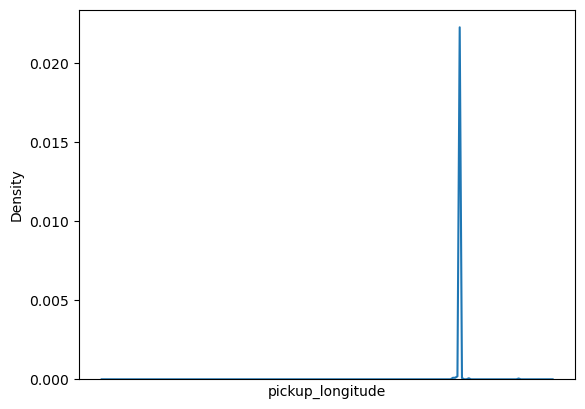

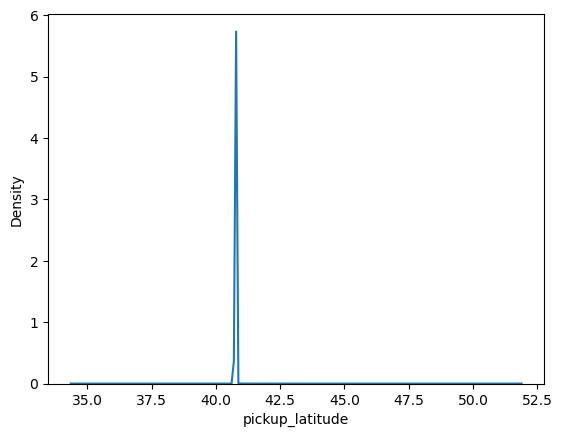

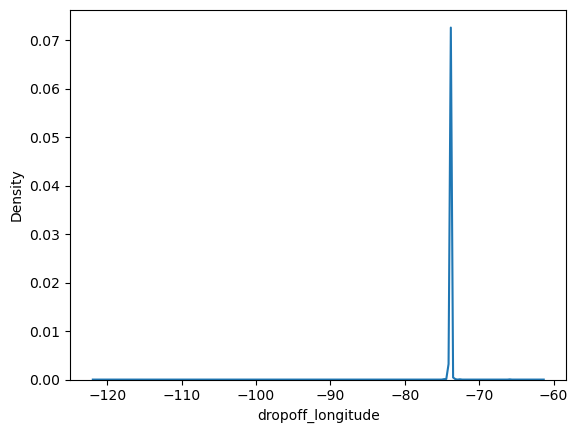

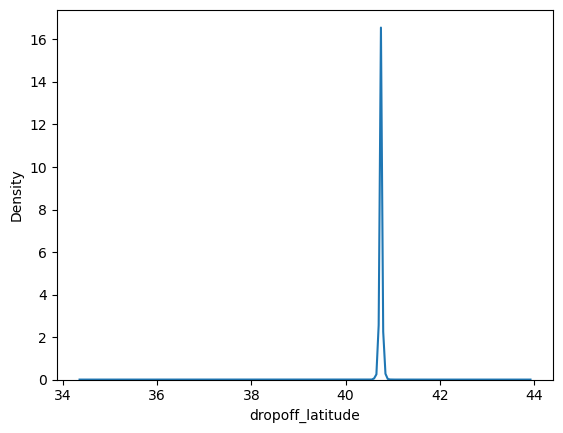

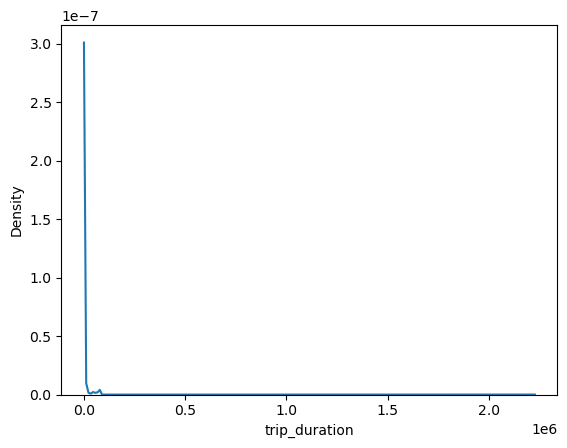

In [58]:
for col in df.select_dtypes("number"):
    sns.kdeplot(df[col])
    plt.show()

In [59]:
df["trip_duration"].skew()

np.float64(202.55575426164614)

We see that `trip_duration` is highly skewed, so we can apply the log to shrink values a little bit.

In [60]:
df["trip_duration"] = np.log1p(df["trip_duration"])  # Shrinking our target value
df["trip_duration"].describe()

count    1000000.000000
mean           6.466492
std            0.794744
min            0.693147
25%            5.986452
50%            6.496775
75%            6.980076
max           14.616441
Name: trip_duration, dtype: float64

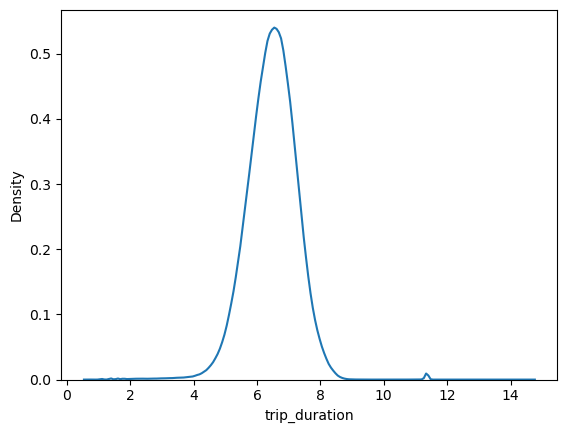

In [61]:
sns.kdeplot(df["trip_duration"])
plt.show()

In [62]:
df["trip_duration"].skew()

np.float64(-0.28179231920239084)

Now `trip_duration` is way better.
We see that longitude and magnitudes are also highly skewed, but we can keep their transformation for later 
(after using them for creating new features)

In [63]:
for col in df.select_dtypes("object"):
    print(df[col].value_counts(), "\n")

vendor_id
2    534793
1    465207
Name: count, dtype: int64 

passenger_count
1    708628
2    143907
5     53635
3     41012
6     33287
4     19491
0        38
7         2
Name: count, dtype: int64 

store_and_fwd_flag
N    994443
Y      5557
Name: count, dtype: int64 



- We can notice that we have few outliers in `passenger_count` where it is unlikely to have 7 passengers or zero passengers, so it is better to remove them.

In [64]:
df = df[(df["passenger_count"] != 0) & (df["passenger_count"] != 7)]
df.shape

(999960, 9)

### 4. Correlations & Boxplot
- Numerical Correlations (corr())
- Categorical Correlations
- Removing outliers

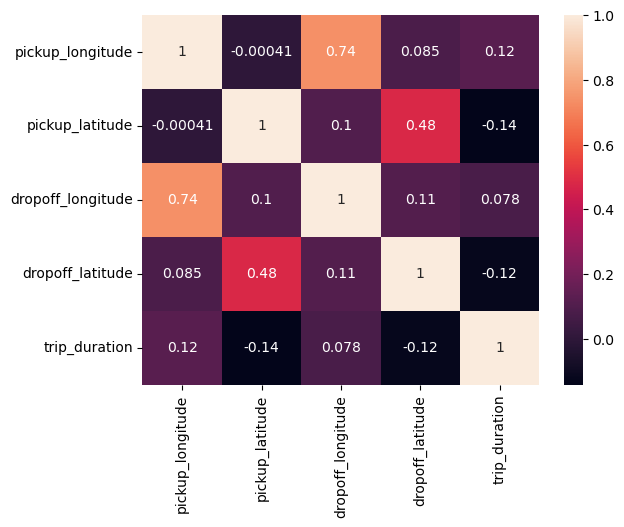

In [65]:
sns.heatmap(df.select_dtypes("number").corr(), annot=True)
plt.show()

As seen in the heatmap above, there is a high correlation between;

1. `dropoff_longitude` & `pickup_longitude`

2. `dropoff_latitude` & `pickup_latitude`

which is probably due to the distance relation between them.
So, we need to remove one of each to avoid any multicolinarity issue in our model.

But before removing, let's try to combine them into one new feature (`trip_distance`)

In [66]:
# Using distance formula:
# https://www.chegg.com/homework-help/questions-and-answers/point-latitude-373198-point-longitude-121936-point-b-latitude-373185-point-b-longitude-121-q56508606

R = 6356  # radius of Earth in km

# Convert degrees to radians
lat1 = np.radians(df["pickup_latitude"])
lat2 = np.radians(df["dropoff_latitude"])
lon1 = np.radians(df["pickup_longitude"])
lon2 = np.radians(df["dropoff_longitude"])

# x and y components of distance
x = R * (lat1 - lat2)
y = R * (lon1 - lon2) * np.cos(lat2)

# Euclidean distance approximation
df["trip_distance"] = np.sqrt(x**2 + y**2)

print(df["trip_distance"])

0          2.756531
1          1.954635
2          1.401424
3          1.974001
4         20.777460
            ...    
999995     1.669307
999996     1.972451
999997     1.665997
999998     6.274394
999999     3.454112
Name: trip_distance, Length: 999960, dtype: float64


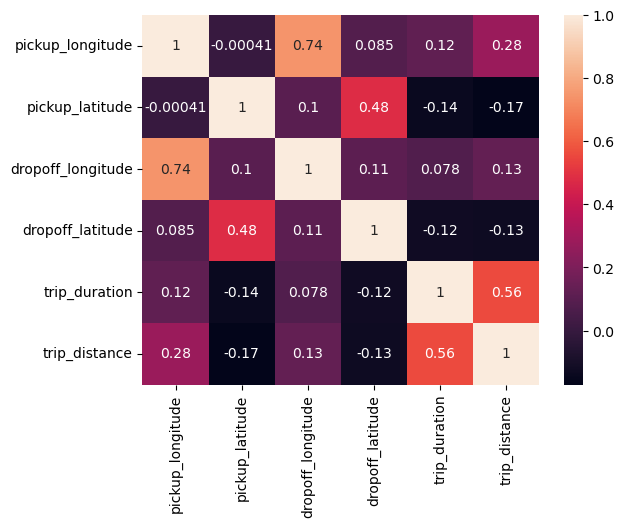

In [67]:
sns.heatmap(df.select_dtypes("number").corr(), annot=True)
plt.show()

We see that `trip_distance` is correlated with the target, which is a good sign.

In [68]:
# Now drop coordinates
df.drop("dropoff_latitude", axis=1, inplace=True)
df.drop("dropoff_longitude", axis=1, inplace=True)
df.drop("pickup_latitude", axis=1, inplace=True)
df.drop("pickup_longitude", axis=1, inplace=True)

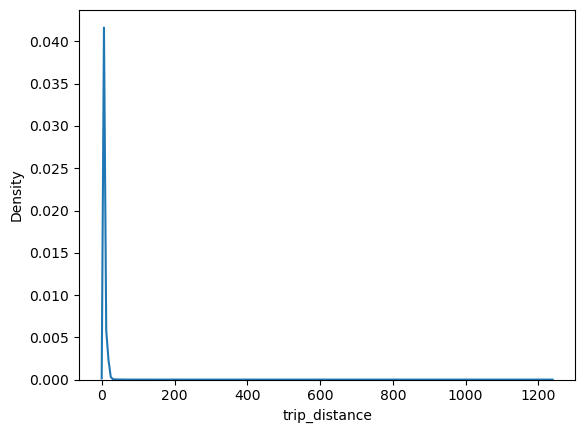

In [69]:
sns.kdeplot(df["trip_distance"])
plt.show()

In [70]:
df["trip_distance"].skew()

np.float64(41.500013159953305)

Since `trip_distance` is highly skewed then we can take log and then check the correlation again.

In [71]:
df["trip_distance"] = np.log1p(df["trip_distance"])

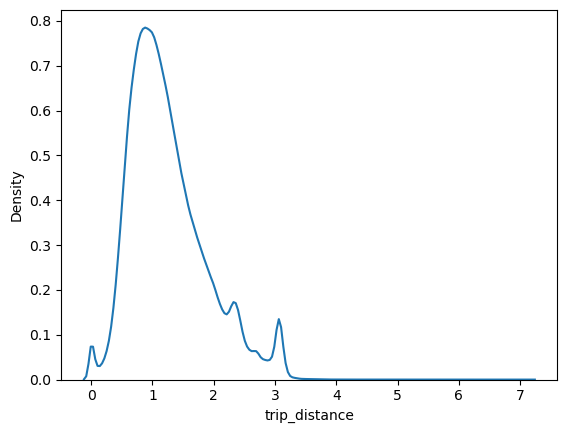

In [72]:
sns.kdeplot(df["trip_distance"])
plt.show()

In [73]:
df["trip_distance"].skew()

np.float64(0.908902521628403)

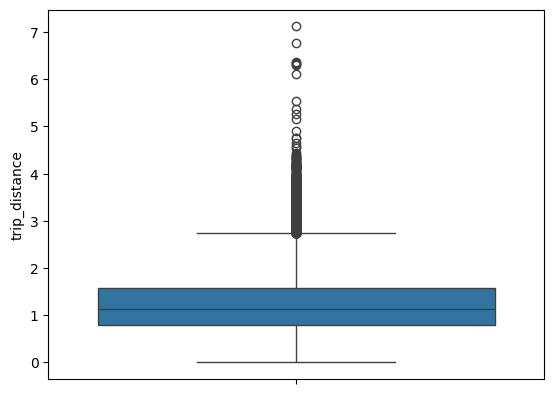

In [74]:
# Checking for outliers
sns.boxplot(df["trip_distance"])
plt.show()

In [ ]:
# Since we have many outliers, we can clean them:
def clean_outliers(df, col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    
    lower_bound = q1 - 15 * iqr
    upper_bound = q3 + 15 * iqr
    
    df_no_outliers = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df_no_outliers

In [76]:
df = clean_outliers(df, "trip_distance")

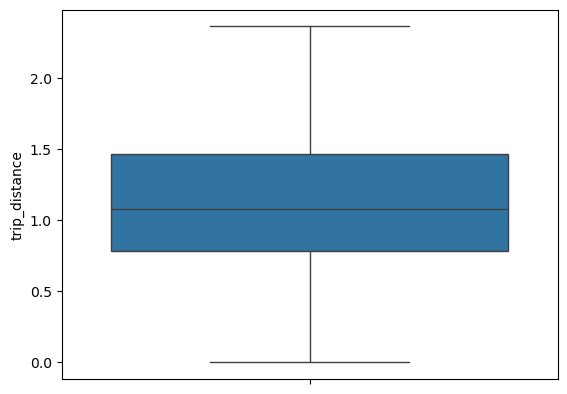

In [77]:
# No more outliers.
sns.boxplot(df["trip_distance"])
plt.show()

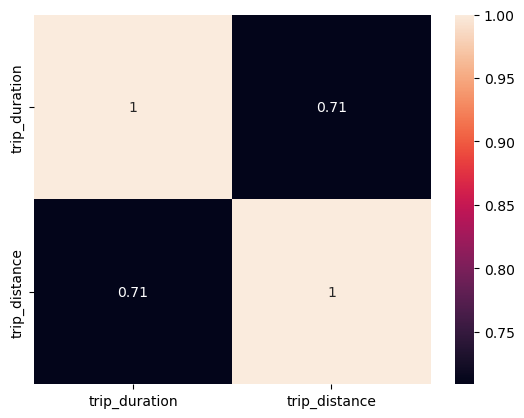

In [78]:
sns.heatmap(df.select_dtypes("number").corr(), annot=True)
plt.show()

Now we have a high enough correlation between `trip_distance` and our target column. So, we can move to the next step.

### 5. Target Variable Analysis
- Distribution of Target Variable (for class imbalance, decide if resampling or weighting is needed)
- Relationship with Predictors (scatter plots, box plots against the target)

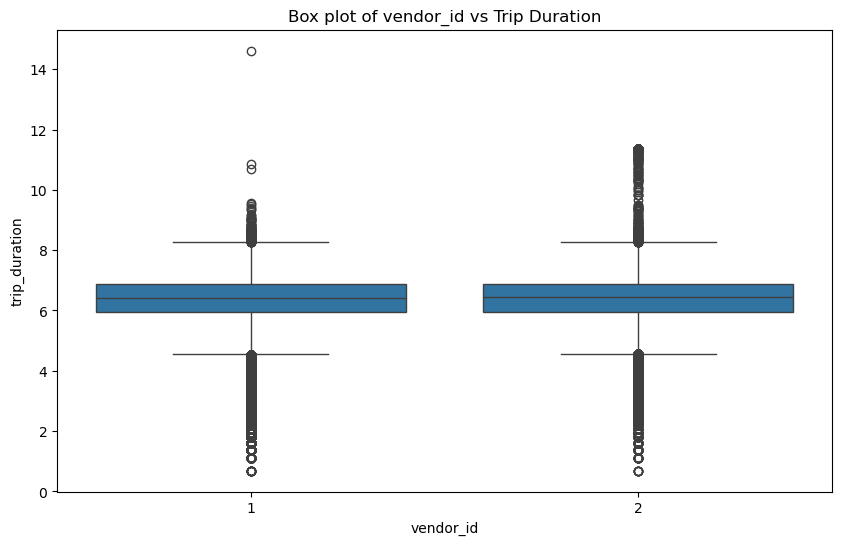

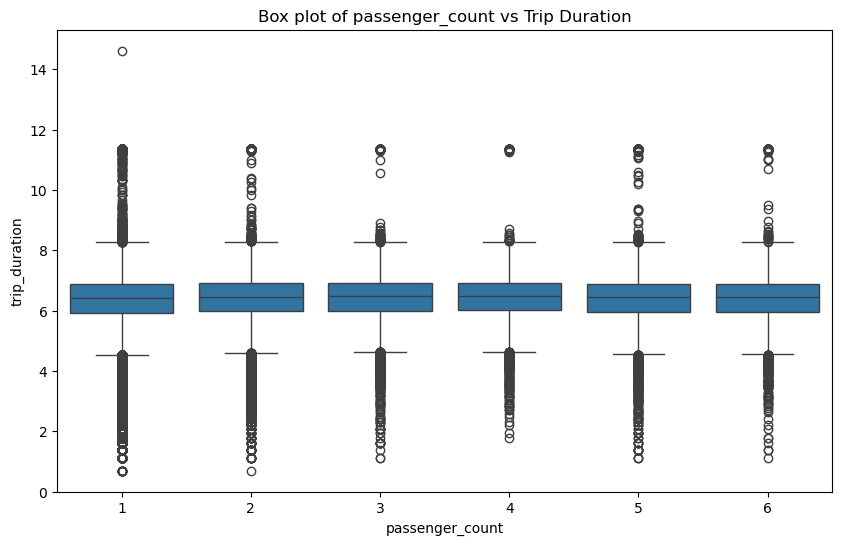

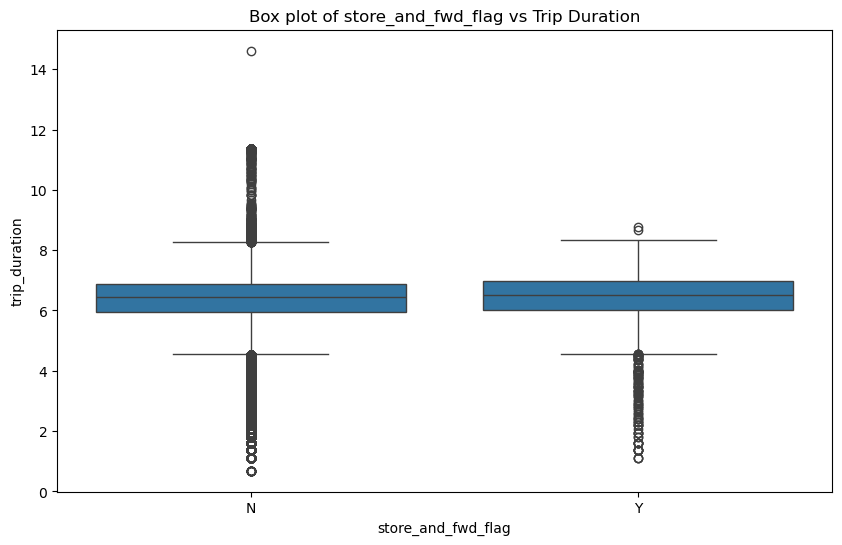

In [79]:
for col in df.select_dtypes('object'):
    top_categories = df[col].value_counts().index[:10]
    filtered_df = df[df[col].isin(top_categories)]
    
    plt.figure(figsize=(10,6))
    sns.boxplot(x=filtered_df[col], y=filtered_df['trip_duration'])
    plt.title(f'Box plot of {col} vs Trip Duration')
    plt.show()

We mainly see that none of the cetegorical features has a direct affect on the trip duration since medians are nearly the same between each feature's different categories. Which implies that we won't need to use target encoding in any of them. Instead, we will be using either one hot encoding or label encoding.

- `store_and_fwd_flag` -> One-Hot Encoding

- `vendor_id` -> One-Hot Encoding

Lastly, let's check the relation between date of pickup and the trip duration:

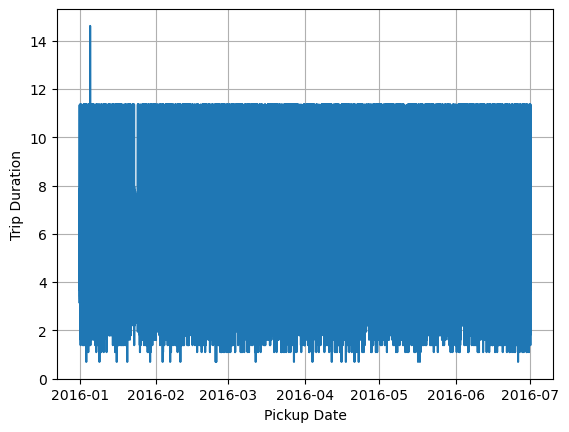

In [80]:
df.sort_values(by="pickup_datetime", ascending=True, inplace=True)
plt.plot(df["pickup_datetime"], df["trip_duration"])
plt.xlabel("Pickup Date")
plt.ylabel("Trip Duration")
plt.grid()
plt.show()

We see few outliers, but nothing in particularly useful.

Since we can't see a useful information like this, let's break the date into 4 main features:

In [81]:
df["pickup_hour"] = df["pickup_datetime"].map(lambda x: x.hour)
df["pickup_day"] = df["pickup_datetime"].map(lambda x: x.day)
df["pickup_month"] = df["pickup_datetime"].map(lambda x: x.month)
df["pickup_year"] = df["pickup_datetime"].map(lambda x: x.year)

In [82]:
df.drop("pickup_datetime", axis=1, inplace=True)

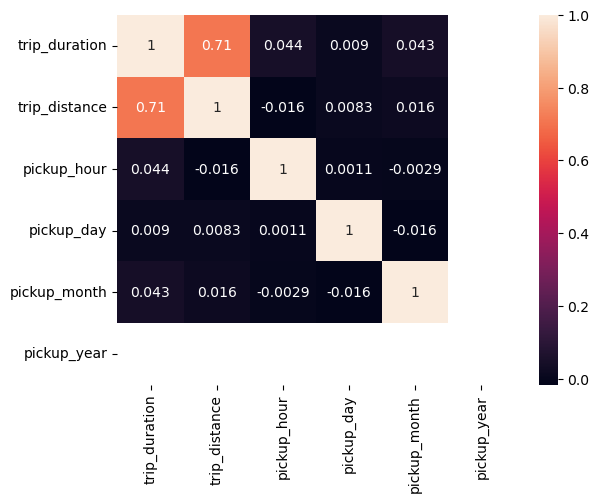

In [83]:
sns.heatmap(df.select_dtypes("number").corr(), annot=True)
plt.show()